# Unofficial Deep Learning Lecture 5 Notes
### Movie Lens

In [1]:
import sys
sys.path.append('/home/paperspace/repos/fastai/')

In [2]:
# !wget  http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [3]:
# !unzip ml-latest-small.zip

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch

from fastai.learner import *
from fastai.column_data import *

In [5]:
path='ml-latest-small/'

In [6]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [8]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

#pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

### Given some ratings:

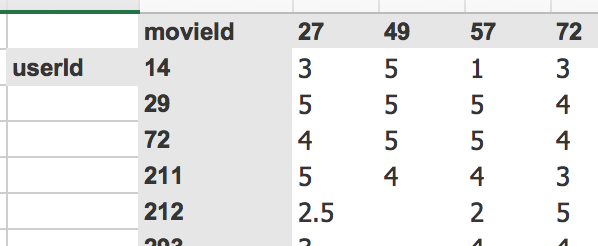


#### Every rating is represented as a matrix cross product (random init)
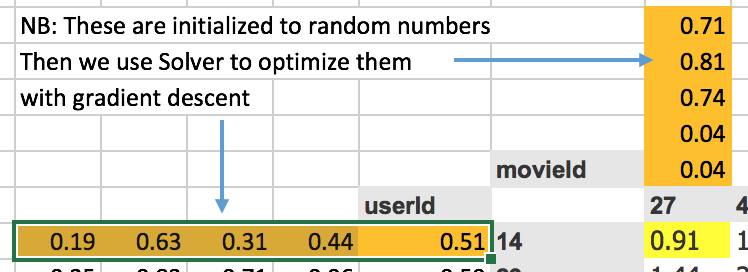


#### Note that windows Office has add-ins. You can turn on the "solver" in the add-ins. This will run an iterative solver



### Now we can calculate the loss
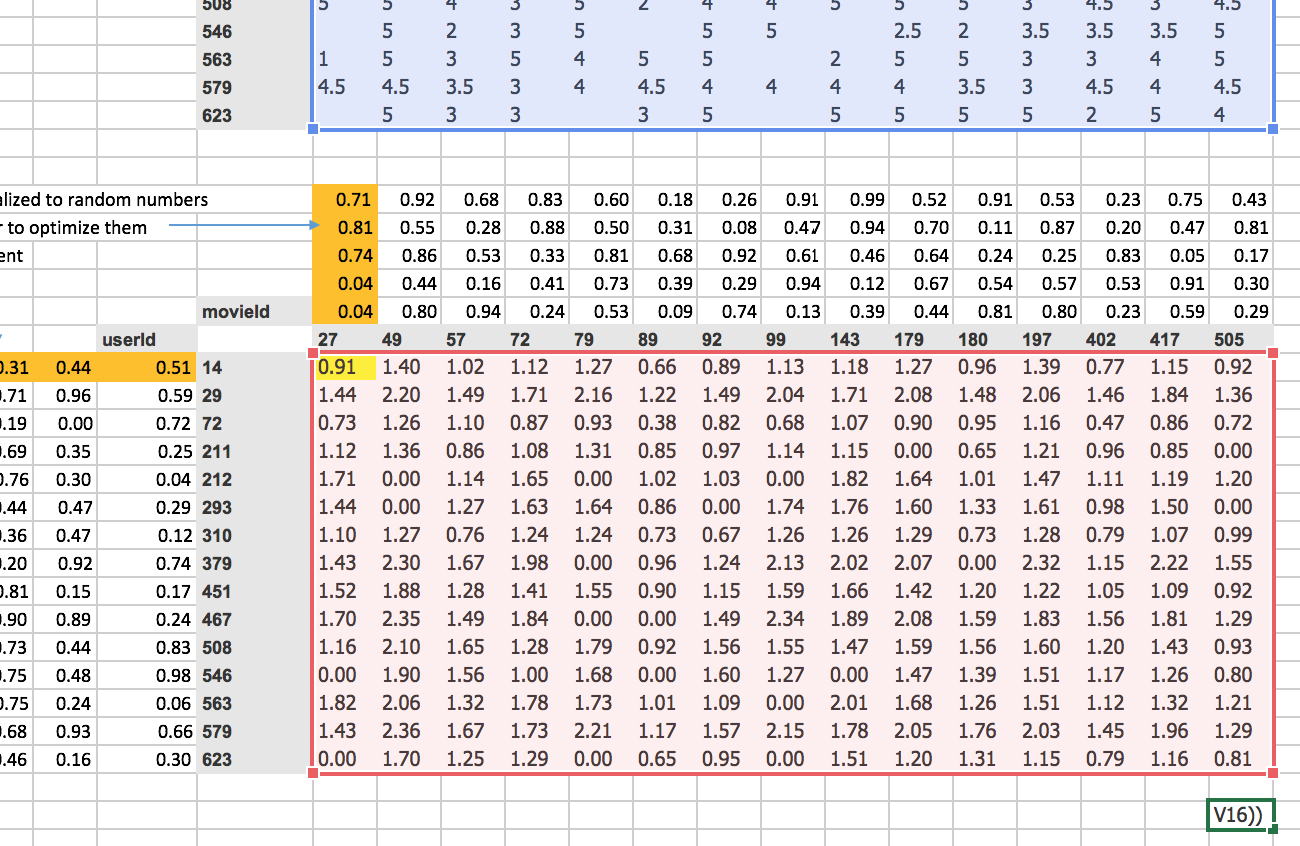

#### And we can then optimize the ORANGE. Based on the loss, BLUE - RED

### Collaborative filtering - High Level

#### Get a validation indexes

- **`wd`** - L2 regularization
- **`n_factors`** - embedding sizes

In [9]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 50

- **`ratings.csv`**
- **`userId`**
- **`movieId`**
- **`rating`** - dependent variable

This movie and user, which other movies are similar to it, which people are similar to this person?

In [10]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')

- size embedding
- index
- batch size
- which optimizer

In [11]:
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

#### Run the fit

In [12]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.84641  0.80873]                                    
[ 1.       0.78206  0.77714]                                    
[ 2.       0.5983   0.76338]                                    



In [13]:
math.sqrt(0.776)

0.8809086218218096

In [14]:
preds = learn.predict()

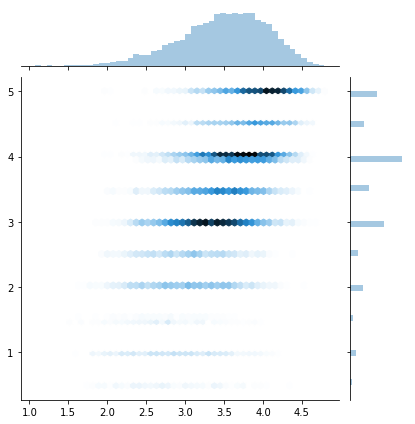

In [15]:
y=learn.data.val_y[:,0]
sns.jointplot(preds, y, kind='hex', stat_func=None);

### Linear Algebra: Dot product example


<img src='https://algebra1course.files.wordpress.com/2013/02/slide10.jpg' style='width:350px'/>

<img src='https://image.slidesharecdn.com/tensordecomposition-170301235239/95/a-brief-survey-of-tensors-3-638.jpg?cb=1488412458' style='width:400px' />

**`T`** = tensor in Torch

In [16]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [17]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [18]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

#### Our First custom layer: We are no making a basic `Torch` class

We are extending the `nn.Module` from pytorch
**`forward`** is a inherited method from the `nn.Module`, which is leveraged by other functions in other pytorch libraries

- `forward` <- matrix multiplication
- `backwards` <- gradients

In [19]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

#### Create an instance of the class

In [20]:
model=DotProduct()

In [21]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

#### Prepare the data:

- look at unique values of user_ids
- make a mapping from user_id to a INT (so there's no skipping of numbers)
- do the same for movie ids

#### Reminder:

- **`enumerate`** - takes in a collection, gives back the index, value for a collection
- **`lambda`** - python keyword for making a temporary function

In [22]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

### Now lets make a more complicated Embedding Layer

- **`__init__`** - this function is called when the object is created. Called the **constructor**

- obj = myClass()
- obj = newClassImade(list)

- **`nn.Embedding`** - a pytorch object

- **`self.u.weight.data`** - initializing the **user** weights to a reasonable starting place
- **`self.m.weight.data`** - initializing the **movie** weights to a reasonable starting place
- **`uniform_`** - note that `_` means 'inplace' instead of returning a variable and doing an assignment


#### for `forward`
    - users,movies = cats[:,0],cats[:,1]
he is pulling both datasets out of the categorical variable.



In [23]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

#### Prep the features and dependent variable

In [24]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating']

#### Pull from a dataframe, with x, y, note that we bind the categorical variables together

In [25]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

#### Setup a optimizer

- **`optim`** - gives us an optimizer. 
- **`model.parameters()`** this is inherited from the `nn.Module`. 
- **`1e-1`** - is the learning rate
- **`weight decay`** - regularization
- **`momentum`**

In [26]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

#### Note: we are not using a `Learner`,  we are using the low-level pytorch `fit`

In [27]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.68932  1.64501]                                   
[ 1.       1.08445  1.30609]                                   
[ 2.       0.91446  1.23001]                                    



In [28]:
### Set the learning rate

In [29]:
set_lrs(opt, 0.01)

In [30]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.69273  1.14723]                                    
[ 1.       0.72746  1.1352 ]                                    
[ 2.       0.67176  1.12943]                                    



### Bias

In [31]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

### Let's improve our model

#### Can we squash the ratings between 1 and 5?

With the sigmoid function we can multiply by our target range
![](https://qph.ec.quoracdn.net/main-qimg-05edc1873d0103e36064862a45566dba)

**`F`** - its the pytorch functional. its a large library of functions used in deep learning

In [32]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = self.u(users)* self.m(movies)
        
        ## add in user bias and movie bias
        ## squeeze is going to be broadcasting, this will replicate a vector
        ## and add it to the matrix
        res = um.sum(1) + self.ub(users).squeeze() + self.mb(movies).squeeze()
        
        ## this limits the range of the ratings
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [33]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [34]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.85056  0.83742]                                    
[ 1.       0.79628  0.81775]                                    
[ 2.       0.8012   0.80994]                                    



#### What's actually written in fastai?


```python
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.05,0.05)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        return F.sigmoid(res) * (self.max_score-self.min_score) + self.min_score
```

### Let's make a Neural Net Version of this

Let's look at the excel

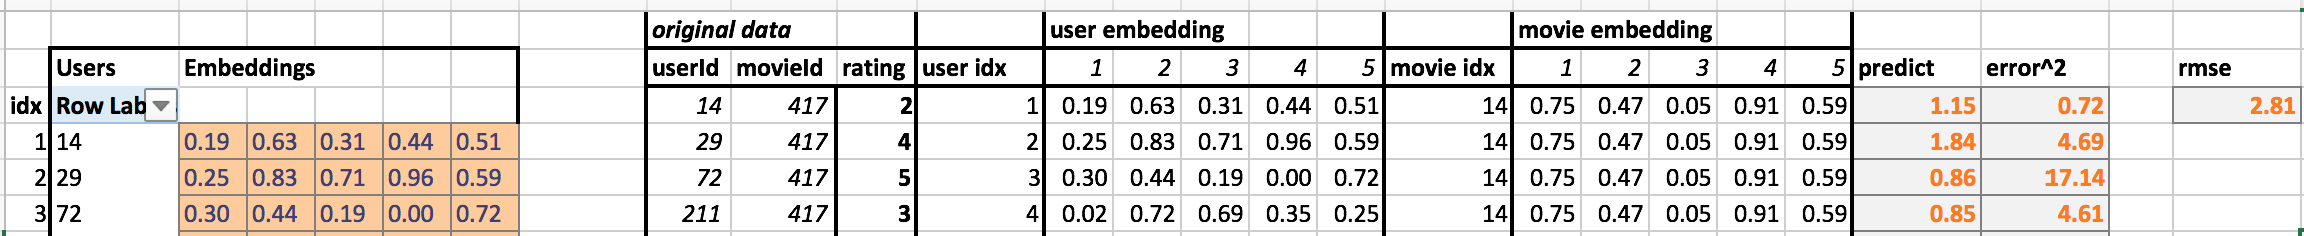


All the users are compared to all movies
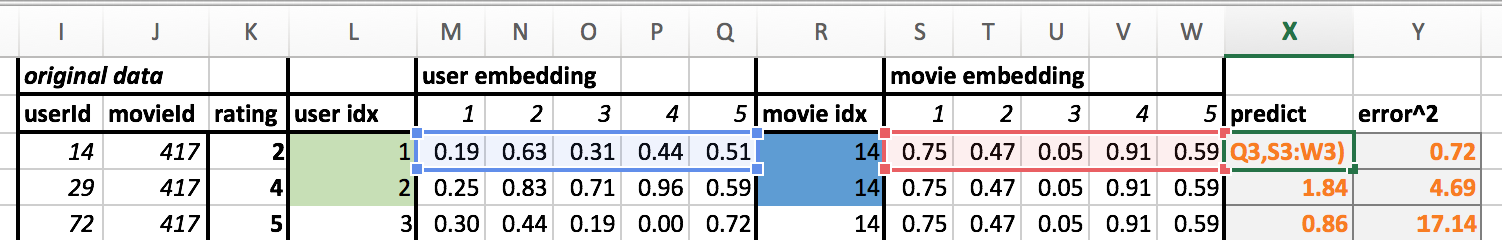

### Why not take the embedding and make a NN out of it?

#### Mini net

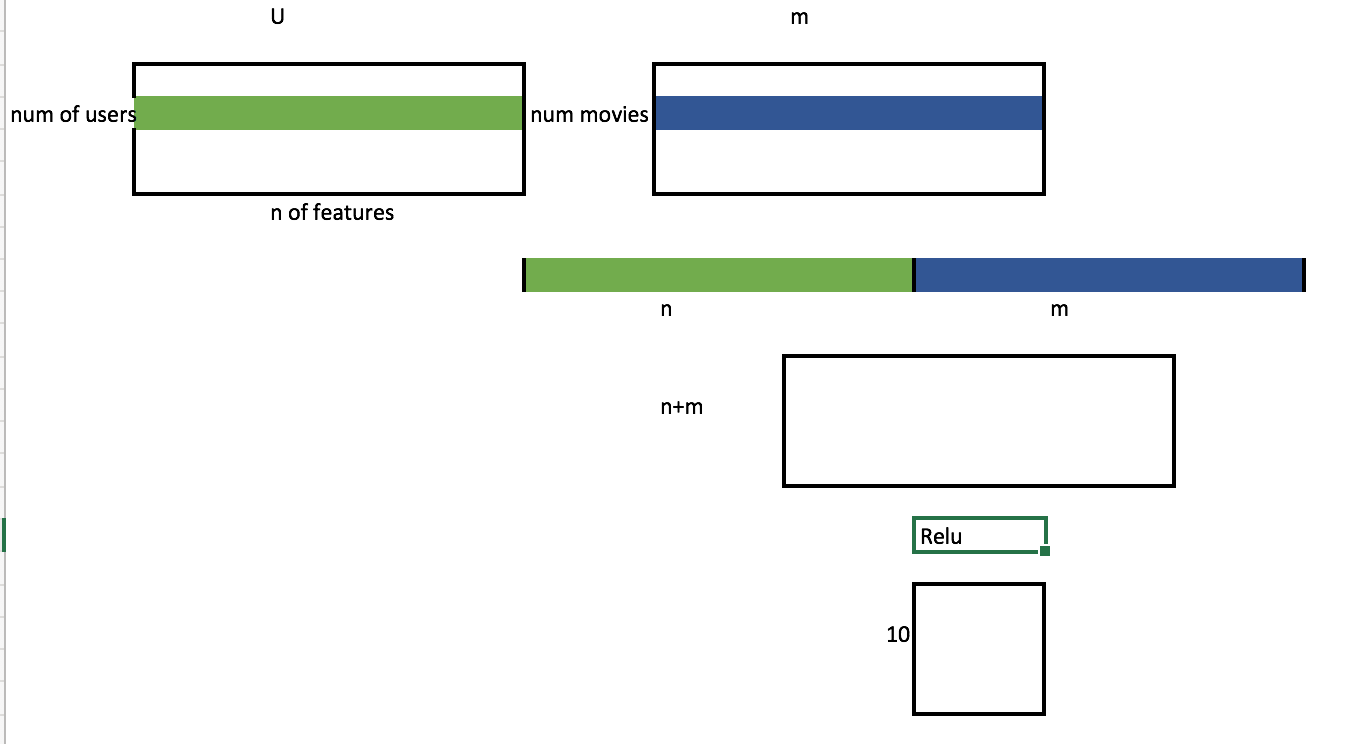

#### Let's prototype our Embedding NN

- `(self.u, self.m) = [get_emb(*o) for o in..` create embeddings
- ` nn.Linear(n_factors*2, 10, nh)` - create our linear layers
- **`nh`** number of hidden layers
- `torch.cat([self.u(users),self.m(movies)], dim=1)` adds the two users and movies together
- `F.relu(self.lin1(x)`
    - linear
    - relu 0, or Max; truncates negative values 
- we have 1 layer, it is a NN, maybe not 'deep' per say

In [35]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, 10, nh)
        self.lin2 = nn.Linear(10, 1)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = F.dropout(torch.cat([self.u(users),self.m(movies)], dim=1), 0.75)
        x = F.dropout(F.relu(self.lin1(x)), 0.75)
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [36]:
wd=5e-4
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-2, weight_decay=wd, momentum=0.9)

#### We will be using mse loss as the optimizing metric

In [37]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       1.0879   1.10568]                                  
[ 1.       0.81337  0.82665]                                    
[ 2.       0.80449  0.79857]                                    



#### Let's explore the learning rate

In [38]:
set_lrs(opt, 1e-3)

In [39]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.68968  0.79054]                                    
[ 1.       0.71873  0.78805]                                    
[ 2.       0.70101  0.78719]                                    



## Neural-Net Approach

- We can add dropouts
- we can use embeddings of different sizes
- we can add more hidden layers with more nodes
- we can add different amounts of regularization

# Talk about the training loop

What's happening inside? 
    - opt = optim.SGD(model.parameters(), 1e-2, weight_decay=wd, momentum=0.9)

## To the excel! 

#### First create some data

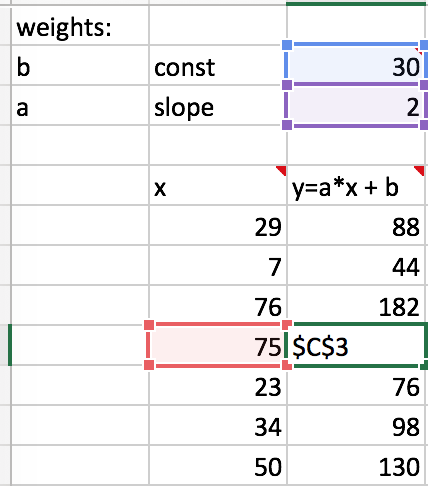

### can we learn the slope and intercept?
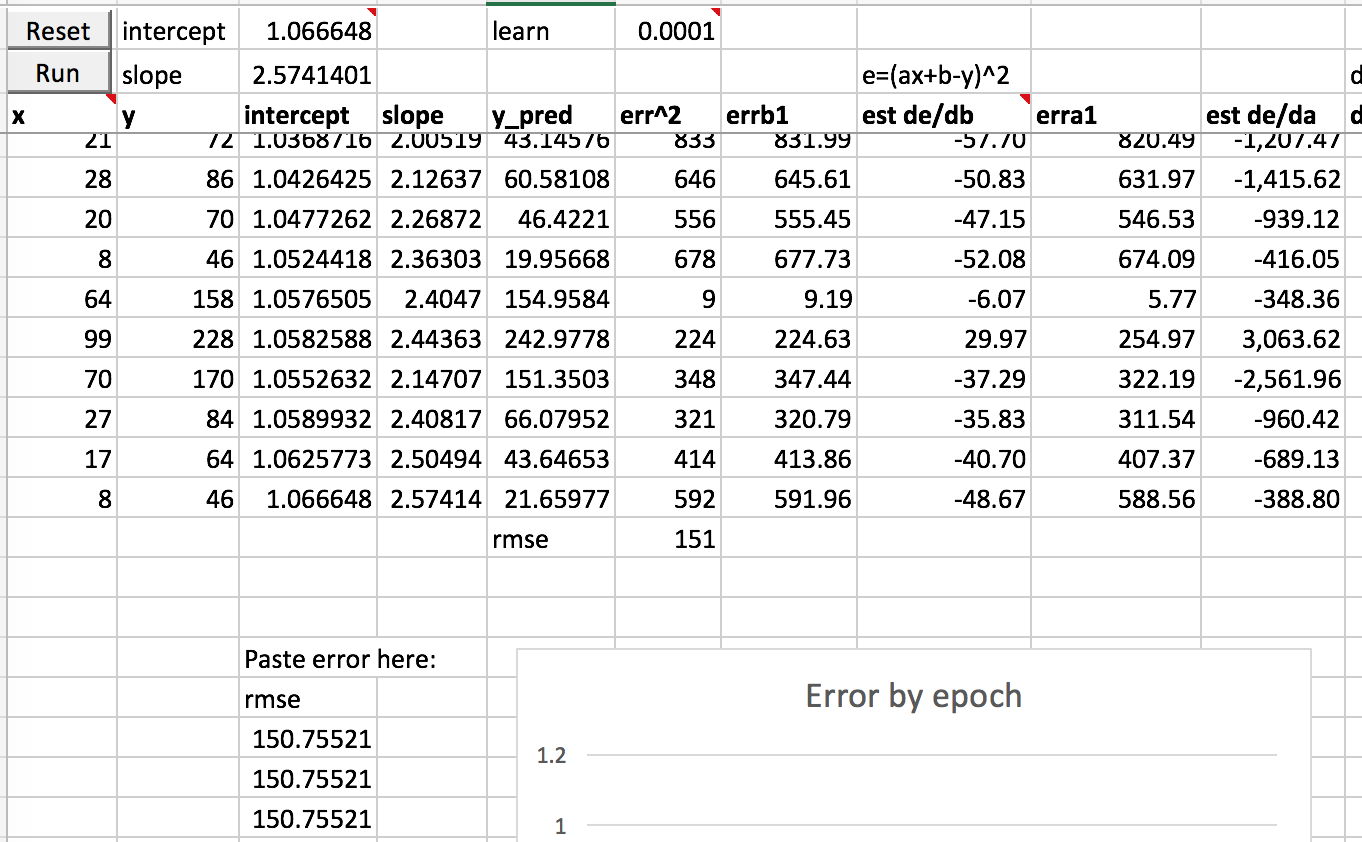

### Lets look at the error equation (err^2=1,849)
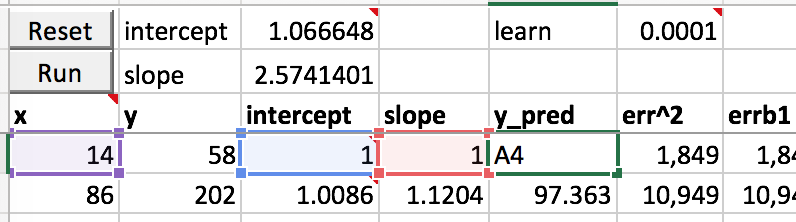

### Increasing the intercept (1.5 up from 1) changes the error (err^2=419)

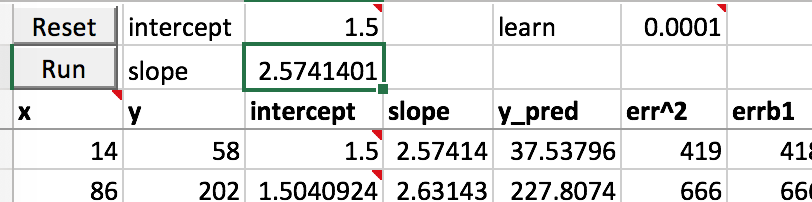

### How can we guess where we should go next? Finite Differencing

<img src='https://i.ytimg.com/vi/v-exTNOSG3g/maxresdefault.jpg' style='width:400px'/>
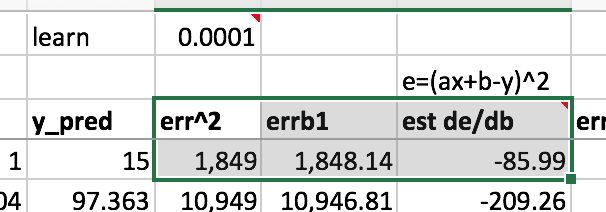


####  A similar related term is backpropogation (the figure on the right)

<img src='https://api.ning.com/files/0gGC4ZQuxjPQZ*7CfZBPKZM7mP-Zfs7mU4MeRsxVnjfhumeFIbr5M1CtJcMmdXjoWl22QlmarTJ2BgMF2ha*2N9jkqfeHUZQ/DeepConvolutionalNeuralNetworks.jpg' />

### Caveat: there's a problem with finite differencing at high-dimensionality

    - 1,000,000 ---> trasnformation ---> 100k
    
When you have a high dimensional space, yoru gradient becomes a huge matrix. The amount of calculation computation that you need is very high. Takes up a lot of memory, a lot of time.

Look up :
- **jacobian**
- **hessian**

More efficient -> find the derivatives **analytically** instead of **finite differencing**

#### Remember the chain rule from calculus (quick aside on how the chain rule works)

#### Explaining the manual calculation of the differentials, ot calculate a new a and b  (orange), then run all back again

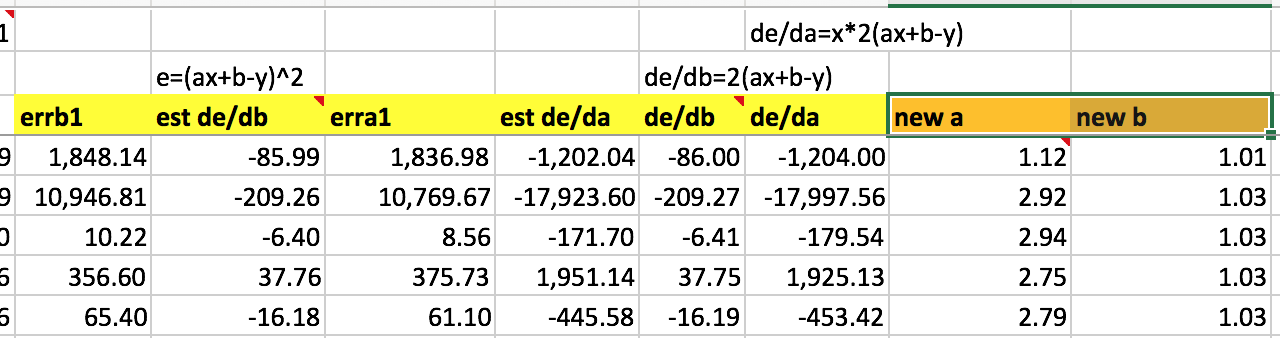

### Momentum: addressing how fast we come to a good solution

- looking at SGD de/da, we see that it is positive and negative at random
- the **momentum** idea is controlled by beta coefficients, will keep the differential going in the same direction, but a bit faster; will reduce the number of iterations
- **adam** is much much faster, but the answers are not as good as SGD with momentum
- Recently, a newer version is out: **adamW** that fixes weight decay issues. Ideally this will be fixed going forward


### About Adam Optimizer: even Faster!

Equals to our previous value of b, times learning rate divided by sqrt()

- `cellJ8` = linear interpolation of derivative and the previous direction
- `cellL8` = linear interpolation of derivative squared + derivative squared from last step
- this is also known as exponential weighted moving average

#### Some inituition on this (reminder, in the denominator)
- squared derivative is always positive
- if there's a big change, the squared derivative will be huge
- so if there's a big change, we divide the learning rate by a big number, (slow down)
- if there's minimal change ( we will be more aggressive in choosing a new learning rate)
- **adaptive learning rate** - since the rate isn't constant, but dependent the model's optimization movements

### Similar idea implemented in fast ai
```python
 avg_loss = avg_loss * avg_mom + loss * (1-avg_mom)
```
From the fit function:

```python
def fit(model, data, epochs, opt, crit, metrics=None, callbacks=None, **kwargs):
    """ Fits a model
    Arguments:
       model (model): any pytorch module
           net = to_gpu(net)
       data (ModelData): see ModelData class and subclasses
       opt: optimizer. Example: opt=optim.Adam(net.parameters())
       epochs(int): number of epochs
       crit: loss function to optimize. Example: F.cross_entropy
    """
    stepper = Stepper(model, opt, crit, **kwargs)
    metrics = metrics or []
    callbacks = callbacks or []
    avg_mom=0.98
    batch_num,avg_loss=0,0.

    for epoch in tnrange(epochs, desc='Epoch'):
        stepper.reset(True)
        t = tqdm(iter(data.trn_dl), leave=False, total=len(data.trn_dl))
        for (*x,y) in t:
            batch_num += 1
            loss = stepper.step(V(x),V(y))

            avg_loss = avg_loss * avg_mom + loss * (1-avg_mom) #<----------

            debias_loss = avg_loss / (1 - avg_mom**batch_num)
            t.set_postfix(loss=debias_loss)
            stop=False
            for cb in callbacks: stop = stop or cb.on_batch_end(debias_loss)
            if stop: return

        vals = validate(stepper, data.val_dl, metrics)
        print(np.round([epoch, debias_loss] + vals, 6))
        stop=False
        for cb in callbacks: stop = stop or cb.on_epoch_end(vals)
        if stop: break
```